In [19]:
import pandas as pd
import numpy as np
import scanpy as sc
import requests
import regex as re
import json
import os, sys
sys.path.append('/home/fvalle/phd/master_thesis/hsbm/')

# Get Manifest File

In [47]:
files_endpt = "https://api.gdc.cancer.gov/files"

# The 'fields' parameter is passed as a comma-separated string of single names.
fields = [
    "file_name",
    #"analysis.workflow_type",
    #"experimental_strategy",
    "cases.project.primary_site",
    "cases.project.disease_type",
    #"cases.diagnoses.primary_diagnosis",
    "cases.submitter_id",
    "cases.samples.portions.analytes.aliquots.submitter_id",
    "cases.diagnoses.tumor_stage",
    "cases.diagnoses.tumor_grade",
    "cases.diagnoses.progression_or_recurrence",
    "cases.diagnoses.prior_malignancy",
    "cases.project.project_id"
    #"cases.diagnoses.vital_status",
    #"cases.diagnoses.days_to_birth"
    #"cases.project.project_id"
]

fields = ','.join(fields)

In [48]:
# 10 tissues project filters only top 10 tissue (@ 18/12/2019) from TCGA are downloaded
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "files.data_type",
            "value": ["Gene Expression Quantification"]
            }
        },
        {
        "op": "in",
        "content":{
               "field": "files.analysis.workflow_type",
                "value": ["HTSeq - FPKM"]
                }
        },
        {
        "op": "in",
        "content":{
            "field": "files.data_format",
            "value": ["TXT"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "cases.project.program.name",
            "value": ["TCGA"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "cases.primary_site",
            "value": ["bladder","brain","breast","bronchus and lung","colon","corpus uteri","kidney","prostate gland","skin","thyroid gland"]
            }
        }
        
    ]
}

In [49]:
# A POST is used, so the filter parameters can be passed directly as a Dict object.
##remove manifest to have file fields
params = {
   "return_type": "manifest",
    "filters": filters,
    "fields": fields,
    "format": "TSV",
    "size": "15000"
    }

In [7]:
# The parameters are passed to 'json' rather than 'params' in this case
response = requests.post(files_endpt, headers = {"Content-Type": "application/json"}, json = params)
with open("manifest.txt","w") as manifest:
    manifest.write(response.content.decode("utf-8"))
    manifest.close()

Use **gdc-client** to download data files.

```bash
mkdir data
mv manifest.txt data/.
cd data
gdc-client download -m manifest.txt
```

In [27]:
#genes filtered as Dey
df_genes = pd.read_csv("https://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None, index_col=0)
df = df_genes.copy()

In [16]:
#fpkm
def getFilenameFromDir(directory):
    for element in os.listdir(directory):
        if re.match("[a-zA-Z0-9]{8}-[a-zA-Z0-9]{4}-[a-zA-Z0-9]{4}-[a-zA-Z0-9\-]{4}-[a-zA-Z0-9\-]{12}[\.FPKM]{5}.txt[\.gz]{0,3}",element):
            cfile = element
            print(element)
            return cfile
    raise BaseException("Not found %s"%os.listdir(directory))

In [28]:
added = len(df.columns)
for i,cdirectory in enumerate(os.listdir("data")):
    if re.match("manifest\.txt",cdirectory):
        print("SKIPPING %s "%cdirectory)
        continue
    if "Icon" in cdirectory:
        print("SKIPPING %s "%cdirectory)
        continue
    cfile = getFilenameFromDir("data/%s"%cdirectory)
    cdf = pd.read_csv(("data/%s/%s"%(cdirectory,cfile)), sep='\t', header=None)
    cdf.columns = ["gene", cfile[:]]
    cdf['gene'] = [gene[:15] for gene in cdf['gene']]
    cdf.set_index('gene',inplace=True)
    cdf = cdf.reindex(index=df_genes.index)
    old_L = len(df.columns)
    df.insert(0,cdf.keys()[0][:],cdf.values)
    if len(df.columns) != old_L+1:
        print(*sys.exc_info())
        raise(Exception("Not able to add: %s"%cfile))
print(added, i)

7c371221-a9c2-442c-80ca-5dc4b52ce5fb.FPKM.txt.gz
ed2f4bed-1958-4e57-a69e-a3714c062d3f.FPKM.txt.gz
5fa81a55-a556-4302-94ea-1249e51511f1.FPKM.txt.gz
77c07069-2887-470f-a1ba-66e5d038912c.FPKM.txt.gz
df959336-a712-47a9-9042-b2b6bc01e813.FPKM.txt.gz
15864159-be88-41c8-bdef-c2c5927cb1a1.FPKM.txt.gz
76b4e454-8b75-449b-98cc-3c41c5e063a3.FPKM.txt.gz
b36cd8b4-bbdc-4b7c-9227-4785e1df93f7.FPKM.txt.gz
62be7dc8-d879-4626-8168-25ccccf341f5.FPKM.txt.gz
9e6d9051-8527-451c-af83-978a7300488f.FPKM.txt.gz
a842f65f-8e47-4ddb-81aa-a4acff6b4963.FPKM.txt.gz
022cbd07-3e20-4144-b2ab-8c76adffae73.FPKM.txt.gz
6cef5fb7-2c60-4ece-87e8-4acff9374fb2.FPKM.txt.gz
ad1d63e4-abf1-43db-95ce-09ee88d6ef2e.FPKM.txt.gz
c22879b5-4183-4c3c-804b-f6cef1df617e.FPKM.txt.gz
de669e2c-67f5-44f1-8c69-f8d014fb1dba.FPKM.txt.gz
161caa2d-589a-4834-9073-3824031da5e6.FPKM.txt.gz
a1231612-345f-4ff4-8ee9-c5e596357f76.FPKM.txt.gz
e94e64de-aeb8-47da-a090-d8551ab8cba1.FPKM.txt.gz
2d5fbcf8-4347-4787-b04d-e84c88316776.FPKM.txt.gz
8a4d662e-e7ec-4c31-b

40d9de72-e2ee-4bd1-9c1f-b5a6df9ce3e1.FPKM.txt.gz
c12052d7-f5ae-4fd5-a36b-ac0ce21179a6.FPKM.txt.gz
88b3eb4d-02ae-4903-89f5-9ee294ee732e.FPKM.txt.gz
0011596d-cfa3-48f7-b182-b1e5765209fc.FPKM.txt.gz
937070b5-0d7b-4289-95bb-98d185ef9249.FPKM.txt.gz
661f0a7e-8262-41ec-8382-c1cf89e3aa8a.FPKM.txt.gz
b033c85a-2395-4ced-a84d-ac1fbce674bf.FPKM.txt.gz
1eef3e97-5670-4b77-bc8d-89a61be03b2a.FPKM.txt.gz
53bbcddc-bbee-4a5c-ae1b-f68a5e7ef01c.FPKM.txt.gz
1ad88d50-b62a-4a36-9304-958944b751f6.FPKM.txt.gz
d8219bec-aec9-4cc3-8864-be208897fdd1.FPKM.txt.gz
08b7568c-c002-43ff-8f86-4be189aada9e.FPKM.txt.gz
78f79907-8bb5-408e-8bec-4dbe0d81174a.FPKM.txt.gz
6b5f99b2-d1e2-4133-8e61-a6b337e6e70c.FPKM.txt.gz
44121978-20e4-4330-8899-67a7557e6d7c.FPKM.txt.gz
350805f4-ae1e-4ce2-857e-3a77e4e6113b.FPKM.txt.gz
9fbf27fa-c33d-443c-a50e-74c731cdeccd.FPKM.txt.gz
4befb3ab-b606-4035-a0b0-639032962767.FPKM.txt.gz
bf9c448b-bdc9-4f74-b13a-374e6add7939.FPKM.txt.gz
339d6e55-7065-45d5-ba2c-afc689cb7386.FPKM.txt.gz
3618bb58-9aa4-4dfe-9

c5127ad6-2af8-429d-a998-0a915d440737.FPKM.txt.gz
6c55db73-80c2-4bc5-8082-195c5620cd14.FPKM.txt.gz
94719fc5-6ae9-410a-a15b-49ffe3753d2d.FPKM.txt.gz
f3e669c1-50e3-485f-9a4c-f365024fceff.FPKM.txt.gz
4d813387-15db-4d2f-bf85-1c79874aa179.FPKM.txt.gz
2b316653-ead7-4cf4-8b6c-e637d86f054c.FPKM.txt.gz
1292e7fb-3199-40e3-a5d1-e141507b3b6f.FPKM.txt.gz
37dfd69b-aa9f-4311-a79e-92a2245e5219.FPKM.txt.gz
8a24d983-1fc9-4f5d-8fe8-aa4ed2a21f7a.FPKM.txt.gz
aaffafa9-2aa2-45da-b8ca-78c0f2b52303.FPKM.txt.gz
676bff6f-27b7-492c-87fd-ef23dc3d23fc.FPKM.txt.gz
0320d3aa-0b8c-4bda-854a-eed5a2d48eda.FPKM.txt.gz
26ab66b2-48c3-4916-b1db-d85d80726683.FPKM.txt.gz
47451ef6-bd1a-4bd2-9cf8-e9e7564a2840.FPKM.txt.gz
00589871-e54f-492f-988f-502670edd606.FPKM.txt.gz
21a4485e-a6e0-4129-8148-3d092ebbdd90.FPKM.txt.gz
6b953214-e5c8-4aae-b257-f7e326ce0b2b.FPKM.txt.gz
06774da7-66ac-4a31-884a-7ea65cbcae93.FPKM.txt.gz
5a1f0513-0e61-4d87-bbc8-1bf0fc75881c.FPKM.txt.gz
ba1a9f7c-9f81-4393-a99b-801f9d3807a6.FPKM.txt.gz
f433e0b0-5a59-48ce-b

af8ce158-69ea-4fa7-978e-4efe1bbd19c1.FPKM.txt.gz
7a4a8942-1cab-4338-86ad-d7eb26c265b5.FPKM.txt.gz
773ee6c9-89ca-46f2-a9b9-8a3773bcc4cc.FPKM.txt.gz
b600c271-e77b-4752-af07-08dd817ea601.FPKM.txt.gz
460fef23-4739-4dc7-b1e2-efd7c262a4d5.FPKM.txt.gz
73fd698d-46d3-4a2a-ae52-91bd00e72b6a.FPKM.txt.gz
2a6ae2e8-733f-4349-8eec-d25e2b4abf86.FPKM.txt.gz
d984a0e2-d502-4003-bdbf-a0364d4e5a78.FPKM.txt.gz
d0ea92d0-3da9-4bc9-afec-4e2971fb047b.FPKM.txt.gz
8266eaa8-ef8c-4e0a-b167-c4d301598b0e.FPKM.txt.gz
8f2c0849-7cd4-4da2-9feb-e3a942b892c4.FPKM.txt.gz
a804f24a-0285-403a-9783-293f16da1382.FPKM.txt.gz
b576af04-e163-4b7d-be4a-eff959d214dd.FPKM.txt.gz
cf588761-e56a-4633-9c47-d4720022feb2.FPKM.txt.gz
6d7f5731-e599-4e3f-b80b-1f0ac2f68111.FPKM.txt.gz
d123ae50-704e-4782-9822-609111fda11d.FPKM.txt.gz
64f1b5f5-28fc-40f6-a27f-547a05dbc6a8.FPKM.txt.gz
95e7a64b-f228-4d19-8e57-a02adde8d01d.FPKM.txt.gz
aab22bf4-8c7f-46b5-8170-844f24a65522.FPKM.txt.gz
0b000450-72a5-4d9b-a22b-fba79f04eb1a.FPKM.txt.gz
709670f6-cbb6-49ac-b

80592959-da54-41d0-9b82-ed279be3ecea.FPKM.txt.gz
48a39e37-0380-4465-8311-6c5c6aff522a.FPKM.txt.gz
f828b2e0-2ad4-4669-9f1e-2ef2dd74706d.FPKM.txt.gz
cbdf8c09-e3f4-4b3e-bdaa-f4a3a4e40068.FPKM.txt.gz
f3ded35b-4e1d-4a7e-aacc-849b4cc0144f.FPKM.txt.gz
43b292be-5d63-4523-a43f-666d20039208.FPKM.txt.gz
e69a2070-7766-4e4a-89f5-5728e2c9590f.FPKM.txt.gz
f9ea29ab-6953-4646-b367-cff2483b9f46.FPKM.txt.gz
ddc5dfb2-e7e4-4159-930e-120c7d2a8640.FPKM.txt.gz
00ea21cb-349a-40c2-ad34-c36e18dcd02f.FPKM.txt.gz
22e30b10-13ff-4b11-bf2a-ff5aac4519ee.FPKM.txt.gz
eb3fc2fd-468c-42b4-bffe-700011c0a918.FPKM.txt.gz
f71ca4cb-1677-41cd-aec1-cd2702fb840e.FPKM.txt.gz
84400ad5-cd37-4a94-a143-5c470599d1ce.FPKM.txt.gz
ca75ae4d-3d90-46d7-9544-fd71dd6c87b2.FPKM.txt.gz
4fa6a1c4-e574-4003-8461-3b494a113644.FPKM.txt.gz
ad417a8f-bc1e-4a1d-84ca-83bcc26ca179.FPKM.txt.gz
b0605c35-5b44-4a32-9af2-7bf863d8da81.FPKM.txt.gz
7c2ce96b-9ada-43b5-a522-91e307379f79.FPKM.txt.gz
49072d20-b1fd-485c-b9c7-6169ce301481.FPKM.txt.gz
36ab490e-d572-4f53-b

631fc20d-00c1-4b13-8520-f25f0388e985.FPKM.txt.gz
4a775326-e623-47d4-b105-d32fc21afb8a.FPKM.txt.gz
68e11add-9274-45d8-a789-1f475e781cd2.FPKM.txt.gz
bf730223-b18f-46ef-b9b9-c94ee729aedb.FPKM.txt.gz
4763c7e5-97e5-40ca-9455-761ac274e0b4.FPKM.txt.gz
e9e955be-706d-464a-afba-37a52b19e092.FPKM.txt.gz
85a57663-89b0-4cc6-b118-98fce8640eb2.FPKM.txt.gz
560da967-7304-4c94-8d03-0fa10f4ae7eb.FPKM.txt.gz
86640b11-93b3-4f4e-89a7-1a1fdc9a414b.FPKM.txt.gz
1315d3ca-da06-40e7-b112-bb6dec37bee2.FPKM.txt.gz
637fbeaf-4bbf-48af-8c0a-4db38b412784.FPKM.txt.gz
21d52318-3b01-49dc-aa80-59426c05281c.FPKM.txt.gz
e24289c6-7bf1-41b8-a30a-47ff254ef336.FPKM.txt.gz
1d975006-4e14-4f2c-be5f-e09f58790d62.FPKM.txt.gz
50124e50-c346-49b6-a493-d9114a7a05cb.FPKM.txt.gz
8ab2317c-97ce-480d-9ab0-c51047031cde.FPKM.txt.gz
79eee19f-5a9c-4e79-83ef-d6871ef4cb6f.FPKM.txt.gz
48024be6-249c-472f-b366-f3dbe9c32219.FPKM.txt.gz
87fcecde-b317-4518-bea1-cc8d14a18107.FPKM.txt.gz
2a2f6758-f11e-4060-bb0d-601e92e7c392.FPKM.txt.gz
83ae9156-437f-4ca1-b

92de83d1-ba60-413c-8d21-d066505fe306.FPKM.txt.gz
4f320b74-5590-434e-88aa-8e9fd04db4f1.FPKM.txt.gz
508976fe-e7a9-4743-a098-2fb0cbe32f8d.FPKM.txt.gz
524d2e99-0526-426f-873d-ea65e27b18a0.FPKM.txt.gz
a33029dd-b5fa-4be0-9cbf-971d289146dd.FPKM.txt.gz
1880aacf-cd87-4a9c-8d53-16507475f3a8.FPKM.txt.gz
1d5070a1-10ea-42e9-bb01-63cadb01138b.FPKM.txt.gz
3067f41a-e3f1-47f5-9545-56d54fa75b98.FPKM.txt.gz
094bf3c0-e72b-46a6-b940-9683a0039dfa.FPKM.txt.gz
c947395a-e0f1-4539-8f56-9c569f01821b.FPKM.txt.gz
e875ae4e-4645-4e84-b0ff-9c9a694717a9.FPKM.txt.gz
7553280c-95f5-482a-87b1-cd237bf15c4c.FPKM.txt.gz
03e36684-a671-4de2-a933-480cf83b2041.FPKM.txt.gz
5b1d889e-c40d-4f58-a4b3-9e9eb0835e86.FPKM.txt.gz
53480dc0-569d-474d-92ae-25e0526c0864.FPKM.txt.gz
345d3200-a399-4eca-b48f-2beeb1689a8a.FPKM.txt.gz
9e0bba8c-ee44-41f6-8b09-7688fe4192a1.FPKM.txt.gz
1f886c5f-c9dc-4bf7-a9f9-30659e57597c.FPKM.txt.gz
da09dd77-0b91-4795-bd80-f90a9784b65c.FPKM.txt.gz
61ff3901-ac66-4d13-956b-d66d7f90551f.FPKM.txt.gz
9c62a984-f89a-4838-a

2cc11440-ca73-417f-9130-82930f3a1152.FPKM.txt.gz
ee4dcccc-514b-4cc6-ae63-6ed3e7519a40.FPKM.txt.gz
589a3a3c-5f90-4caf-aed9-70507015c622.FPKM.txt.gz
29890f2d-efa1-4cf5-8c2b-32951eef6dc6.FPKM.txt.gz
a5274e64-8bf4-4315-99cb-2f8173481fbc.FPKM.txt.gz
51a350d6-9e41-47fc-b0cc-1c7e490e33a6.FPKM.txt.gz
4fb80022-8f80-4992-b1aa-0f678c941878.FPKM.txt.gz
74d699e7-e9f5-4bf7-a939-c32493016921.FPKM.txt.gz
243ed771-e141-4e29-9c42-32838d04f09a.FPKM.txt.gz
f83b0459-e485-4988-bdce-5a217b454d8b.FPKM.txt.gz
6d27be54-6210-431e-b460-247587c5ab8d.FPKM.txt.gz
f311b81e-f58e-4dac-be2d-5a39c19399ac.FPKM.txt.gz
6a4a1e31-bdb9-465b-9e42-4ec02e9b152e.FPKM.txt.gz
70f99dbf-42bc-439c-b562-c51b8e54234e.FPKM.txt.gz
15a0c1b3-fe5c-47d4-9675-7bf8ec838e3a.FPKM.txt.gz
494ca558-baef-4580-9662-19f2b8527858.FPKM.txt.gz
473d25c0-b59f-4adf-a385-6a2f71cf5d29.FPKM.txt.gz
298d4abf-31eb-4155-904a-1b8f4fea371d.FPKM.txt.gz
fc6f1676-b097-40f8-9c0c-fc8142cf5be3.FPKM.txt.gz
c3ed7c7a-b80a-4de2-8dfb-b60bcf336375.FPKM.txt.gz
56b1cfde-d0f9-472f-b

97ae61b2-1b02-4084-a949-8c7dc1073139.FPKM.txt.gz
4d1d5980-606e-4796-9791-0373ef627b52.FPKM.txt.gz
e2954828-68af-490a-ac7d-16140c82a0ea.FPKM.txt.gz
0c2381c5-4134-44a4-ac41-e141e89e1b1f.FPKM.txt.gz
000f9b51-4747-4d7f-9ecc-25bef9b25ad7.FPKM.txt.gz
63ef0e0b-c1c5-456f-8d81-d9da92c22116.FPKM.txt.gz
658a7453-f1b3-46a3-91d6-1b3381be782f.FPKM.txt.gz
90629e6e-2e1e-4f31-884a-6bca2c24ce11.FPKM.txt.gz
38f141c2-4d24-45a7-bc7f-ecdba7082f72.FPKM.txt.gz
270906c7-7a4c-4684-8c48-c4e337f5d9fc.FPKM.txt.gz
816d1c10-f45b-47e6-b090-1d1989520bb6.FPKM.txt.gz
18ea0e96-a76f-42ae-a340-019b24823d26.FPKM.txt.gz
2eb359c8-470a-47b4-a448-eb45df341862.FPKM.txt.gz
08c5dec2-1521-4c5b-90fc-1d17306a6da0.FPKM.txt.gz
63a5626e-aca1-4920-b101-eb5a66373fc0.FPKM.txt.gz
b465a217-2ba3-43c2-aa76-3420679cc05a.FPKM.txt.gz
486a3295-4aea-4023-b9e7-5ef683cd9808.FPKM.txt.gz
c2e72857-11fb-4663-bf9a-bd2089d070fe.FPKM.txt.gz
8c36d9be-a7fb-46d3-9ef5-be7fe874873c.FPKM.txt.gz
dc63da49-8faf-4912-aa74-f37154384746.FPKM.txt.gz
5931cfde-d4dd-4538-a

04ebd1b2-5cc6-448d-a351-58cc73a8d094.FPKM.txt.gz
b4661ac5-95c7-450e-8797-b2dbe04ad1ee.FPKM.txt.gz
18c4e21e-2f12-4d7f-a0d7-85d812eccce6.FPKM.txt.gz
31e5c917-1866-4156-9eaa-84a72c310edc.FPKM.txt.gz
3ca87ae7-bb82-486c-9030-d9331efd6b67.FPKM.txt.gz
c14f98e2-8e9b-49f4-a244-3d06c6cb7126.FPKM.txt.gz
c7a7d3d9-6171-41cd-99c6-5c80f48c6625.FPKM.txt.gz
5a092f95-7774-41ed-b70c-58ed1daa0cf1.FPKM.txt.gz
9b10bf05-b126-42be-9312-cfbfdc888f3e.FPKM.txt.gz
71f14da0-9c2d-4ff8-b57e-0731ff1c27a6.FPKM.txt.gz
bad1164f-36ae-47a6-8c9b-037479000ed8.FPKM.txt.gz
0aa8097b-26b0-4b82-bfab-a5c52d39cf5e.FPKM.txt.gz
f3bc810a-edc7-4412-9e09-006c0bcf2550.FPKM.txt.gz
912ba495-3e5d-45bf-b2aa-a7f8b8a8a2f6.FPKM.txt.gz
ee79e954-2c9a-44ee-95be-03763ea5c395.FPKM.txt.gz
2723b8fe-33ae-477f-ab0d-f5685f26b17f.FPKM.txt.gz
1324ee08-213e-44c7-b28a-849d091ce308.FPKM.txt.gz
d2ba49d2-5207-495c-97b3-d70ebef30c7d.FPKM.txt.gz
11af37ac-3bdb-49b9-bb6a-1eb570a8297e.FPKM.txt.gz
a506e085-33bc-432c-bffc-5dd858bcfb3f.FPKM.txt.gz
192fb5a0-8ee2-4c96-a

32a115cf-570f-4ad9-a123-8e1970062f51.FPKM.txt.gz
95aa2890-118d-48a8-a5d2-53caf27528b2.FPKM.txt.gz
ed22ecf9-2215-4bc4-a660-f8dbd2e2d15c.FPKM.txt.gz
066a17b9-c724-4390-9a5f-d46cde556de3.FPKM.txt.gz
bf7d8fed-3bac-4a79-8c27-12785590bea5.FPKM.txt.gz
045ec00a-3938-4280-959a-f853e53261dd.FPKM.txt.gz
cf6e46bc-d942-4863-9804-4409ba48099e.FPKM.txt.gz
fd3c752c-4a40-4ae9-bfb0-b0315eca3d1d.FPKM.txt.gz
f29ec34d-6066-425a-bccf-1dae2afb43a8.FPKM.txt.gz
d72fd13a-564a-4a11-9ced-8c891c91bfb8.FPKM.txt.gz
3034107c-316d-4dfe-a254-5095e78674cb.FPKM.txt.gz
058cd2dd-6bea-4188-8bb2-3314723c0762.FPKM.txt.gz
0b0f745e-573f-4ace-9431-6b17c550b878.FPKM.txt.gz
efadff8b-a7db-4032-9f02-11c16b3452fd.FPKM.txt.gz
f488d4bd-07b5-4a18-b6e8-982c6303f4a9.FPKM.txt.gz
590db39a-029c-4f4b-9bcd-aec5d18580db.FPKM.txt.gz
f95c523a-cfb0-4b7e-9a66-48dcf9d24515.FPKM.txt.gz
15a8de4a-d360-45ee-8fd6-a069f9b33305.FPKM.txt.gz
344d2093-8816-4f3b-a38c-cfc7ae7cd6ba.FPKM.txt.gz
95ffbe8d-1a65-48ca-a3f4-ce05a5fd5201.FPKM.txt.gz
3a657ffc-d6c1-44a6-8

97745843-751b-4437-82e0-31ed8c323e91.FPKM.txt.gz
a7cbe257-b699-4363-94ce-a65ec0b5b85f.FPKM.txt.gz
20985140-36fe-4ff1-9f81-55d0579fa920.FPKM.txt.gz
d7ac1c65-c9bd-4641-8e54-75280c2b5050.FPKM.txt.gz
fcdaa827-e263-46e0-8a83-206fa5a009ba.FPKM.txt.gz
d1c52e51-385b-44d4-b119-6ee3883017f8.FPKM.txt.gz
c909a75f-23e8-4c96-82f2-72e46fdb8155.FPKM.txt.gz
29aca450-15a5-4d45-bade-ecce8e5a0e8f.FPKM.txt.gz
9bb09b83-b276-4402-a02e-3c0c6e054e18.FPKM.txt.gz
a8cccaa0-76de-4b73-8f73-85fce2bc278b.FPKM.txt.gz
3ff465f0-6c58-41eb-bad1-15bd5cd80531.FPKM.txt.gz
924404bc-79bf-433e-b52a-614f4ef0e23d.FPKM.txt.gz
c9b778fa-3a42-4447-8788-efa1dec49899.FPKM.txt.gz
8ec5a017-d4e6-401f-b057-85583a8e891c.FPKM.txt.gz
096e442a-b0ce-4d28-b901-a84e0d752ec4.FPKM.txt.gz
786873b7-1515-4aaf-872a-ee2e0ee05bf2.FPKM.txt.gz
f770d34c-308f-4950-a6ef-103a14faef26.FPKM.txt.gz
606767dd-9844-4bcd-851b-fe7a81442d56.FPKM.txt.gz
b80cedff-e07c-4325-975a-55d1d0bb5afc.FPKM.txt.gz
8b4a22e2-e19a-4f8c-9f8f-a19f69fc8cbf.FPKM.txt.gz
dd1d19b2-681b-447b-b

385728ce-d2bc-4fe5-bcab-59f775c1e0fa.FPKM.txt.gz
85f00b2b-bee0-4bed-bf31-a344b0fe64a8.FPKM.txt.gz
339bf596-e9a9-4d65-b61f-294f410dd1c8.FPKM.txt.gz
41b4a929-42ae-411a-9578-a3e7ae35e338.FPKM.txt.gz
d876380c-cad9-40e7-a627-f2fd2322509c.FPKM.txt.gz
549a08ff-7895-4697-bb4f-a16104710057.FPKM.txt.gz
c643bb69-8c28-42bb-b7b8-1e27f0a46cfb.FPKM.txt.gz
be0ed1d4-ca61-4574-9efe-0177b00c9f09.FPKM.txt.gz
ae6bc5cc-3d10-4cf1-a58c-ba51f2764aa9.FPKM.txt.gz
5a58850f-397c-4786-8141-2d57dd974673.FPKM.txt.gz
e9a0fc7b-94ea-477d-918a-1ef80fefefcd.FPKM.txt.gz
de3d2ca0-d59f-46b3-9b15-fad972cfa86e.FPKM.txt.gz
f16f3a7f-172b-4846-afe2-121629eec959.FPKM.txt.gz
92aa8637-25d7-429e-aa0f-46f63bb22800.FPKM.txt.gz
60da5b9c-f663-414c-88f7-98a21ddffd15.FPKM.txt.gz
5dbda4c9-1f30-4800-9b81-cadf31b1b5d9.FPKM.txt.gz
a466927a-fe3d-4efe-9509-3a08338fe859.FPKM.txt.gz
56dd8737-fd50-481b-864a-940760613b52.FPKM.txt.gz
7483525d-d141-4e9d-aced-92be415ec529.FPKM.txt.gz
73bd0051-b4b9-4156-85cc-e550c32080f1.FPKM.txt.gz
13918b1d-75f3-4195-8

96833a09-14ce-4483-b17d-f4328e0b68f5.FPKM.txt.gz
f9b34a21-993b-4eb7-a383-5cd41cd56ab9.FPKM.txt.gz
d8e6b946-9f27-4f9a-9a0e-f9eacbf69bc8.FPKM.txt.gz
df652972-6474-474a-9745-4b58fff68744.FPKM.txt.gz
3cb1f903-64b3-4f84-9ed7-9e3fb8f4578c.FPKM.txt.gz
fe898d64-faa4-452c-b8ef-cfec7250a286.FPKM.txt.gz
fa3d5856-e25b-4d4e-94ac-f524dc8a4cf5.FPKM.txt.gz
b5631f88-a4cd-4ec6-b0e9-30512aa38728.FPKM.txt.gz
93bc97c3-4943-47e3-82ce-8517b2a65c30.FPKM.txt.gz
cfcd8eb5-9864-4463-8d83-d76c6f5dbe54.FPKM.txt.gz
de2ffea0-e172-45e2-aa15-f543758deb78.FPKM.txt.gz
3add0a93-4d4a-44e6-a85a-f2f0915e03c0.FPKM.txt.gz
e1225b5a-c7df-4305-a4cf-35ef372240f3.FPKM.txt.gz
bc5738b1-7d71-4c40-969f-68616ed01345.FPKM.txt.gz
844c1614-007b-41eb-89ac-e81667c98743.FPKM.txt.gz
63404d01-9685-4a55-9319-202e5f5abf79.FPKM.txt.gz
bdaf566b-2c4a-4194-be7d-f8fdcee904ee.FPKM.txt.gz
208e8d62-0277-404e-9246-55d36eb3ec7d.FPKM.txt.gz
74df62d7-45f0-47c3-b0fd-8b47ed7324b8.FPKM.txt.gz
8f6ec7f3-e417-4978-b866-ca4e488fada5.FPKM.txt.gz
60698050-9b14-4ba9-b

f5e4c398-d9db-4cd0-bd12-3751a624d377.FPKM.txt.gz
70129edf-3380-48eb-8a5c-1230a92ec6c9.FPKM.txt.gz
9d069f52-1dbe-424a-b1f9-d88ce964c93e.FPKM.txt.gz
7e5759aa-8b94-4c50-8d62-779c69e29b79.FPKM.txt.gz
925fafd4-8868-48dd-81e6-f6b6ca6de0fb.FPKM.txt.gz
43b83f4b-dea9-4821-902b-d600fe8c03e7.FPKM.txt.gz
08b60e36-2683-4650-bcf4-0fe4af20607f.FPKM.txt.gz
cf7616fa-d5c6-4430-b644-aaa63bbf2704.FPKM.txt.gz
86b85802-2fb0-4628-a79f-04bdb80b7461.FPKM.txt.gz
264a885b-95a5-456a-a821-140e65f6c008.FPKM.txt.gz
4869e2a4-f182-41f1-8aed-52b5dd3b5c00.FPKM.txt.gz
69630696-e0c9-4bc1-8205-54d240e81ee6.FPKM.txt.gz
1785abbf-4f85-4a72-8365-44c743ea786b.FPKM.txt.gz
74820fcd-2e21-4de7-aabf-bdea4842046a.FPKM.txt.gz
f125d4a1-cb15-4729-9318-433c39c685d7.FPKM.txt.gz
9447e559-9df9-4517-9f1e-7b280cc4293b.FPKM.txt.gz
789db3c8-c5cd-428d-aaef-e3f60c40bc9a.FPKM.txt.gz
c0055307-e827-4621-82ff-9702ae53df10.FPKM.txt.gz
673b5bd8-a5b6-4b19-9a9d-4bcbc6988ab1.FPKM.txt.gz
3532ec0a-2563-420a-b71c-3dcc632ef477.FPKM.txt.gz
cb5bd5dd-47fa-4e11-b

9a258d14-23ec-4d25-902d-a2839d76a809.FPKM.txt.gz
c8fd69b8-365d-4802-aed6-619956545feb.FPKM.txt.gz
a5b3d923-511f-4db8-989b-97e1ffe59b96.FPKM.txt.gz
67f03128-5448-49b9-91d9-8a8e68b10cc5.FPKM.txt.gz
6c0fb168-4aa2-444b-9909-6437f0eab2a0.FPKM.txt.gz
8309be46-0342-49d9-b6f1-b2779eaaee9a.FPKM.txt.gz
8c35357a-dc7c-4e70-bb53-ce8f520bdb86.FPKM.txt.gz
17e8f188-45e4-4ed2-8953-2d5f0760f244.FPKM.txt.gz
1a552b38-4a08-429c-baff-dd07380436d8.FPKM.txt.gz
0a3f430a-7e5e-4e68-92cc-f767da7e361c.FPKM.txt.gz
d91854e8-4693-42c9-8f83-3152d42b2213.FPKM.txt.gz
72091aa8-e5a3-4468-8604-e5fbfefe5971.FPKM.txt.gz
0b6603e7-a619-40d0-8af8-ddc7d30ffd7e.FPKM.txt.gz
e53da5a7-c010-4e73-b2d1-cb02a84459fe.FPKM.txt.gz
130e22b9-5b91-437a-88be-aefaced5bb5e.FPKM.txt.gz
b4100ce6-2507-4ba9-a3d4-b47810c9ba99.FPKM.txt.gz
f6b88701-3fe1-4687-848f-14f8a3c8c0f4.FPKM.txt.gz
0b27a4e5-3e45-42e7-a965-3e7eb02c037c.FPKM.txt.gz
69878c97-02ab-4504-9506-aea3adbee455.FPKM.txt.gz
42d4f4c7-690c-4c0d-a2e8-ad3aef6f7776.FPKM.txt.gz
e26db93d-c41d-4048-9

80980cc8-30b5-4668-a7ea-e3cca5a44e2f.FPKM.txt.gz
b07b373c-29e1-4e88-a3a9-783568cc12eb.FPKM.txt.gz
1d293e9f-7672-428c-be8d-3d180c8e8590.FPKM.txt.gz
d81394e3-a55e-4b85-b13d-e3fa1806c800.FPKM.txt.gz
e227370b-332f-4fba-9a48-b894f88df55f.FPKM.txt.gz
c8c58445-3c7f-4c98-85b0-6a707c3d8473.FPKM.txt.gz
02f80b77-c836-4b00-a9c3-efd760d093b1.FPKM.txt.gz
447f0731-1dfc-4c5e-9641-43e2d0a2af43.FPKM.txt.gz
7d4d3a36-6f6a-4e91-8849-cc871fb6cf4e.FPKM.txt.gz
0751ff85-93a8-4d4b-a7bd-e1dc9abc07ea.FPKM.txt.gz
92e4e583-3efe-4144-9247-eaad758b0944.FPKM.txt.gz
2092ab0d-6040-4a09-b175-bda5ebc9998a.FPKM.txt.gz
a0cb35f5-0d64-4fb9-9747-acf4cfc88012.FPKM.txt.gz
ce31f4cb-91e3-446e-8a42-e34352f8b45e.FPKM.txt.gz
521cf209-e415-4352-96d7-aef7c1d564c0.FPKM.txt.gz
8e1ffdc2-b7ab-450b-b6da-2234aa78626a.FPKM.txt.gz
5d72242b-938d-43cc-ba30-015ffaca9986.FPKM.txt.gz
a9cda68e-2f29-424c-a9d4-1e31fd1a7d8f.FPKM.txt.gz
dcaf948d-c02a-4b7b-913b-e91c74b7641c.FPKM.txt.gz
38ad91d3-6058-4714-b442-4bb12813d5ea.FPKM.txt.gz
ba3feee9-9672-4379-a

9f7d2a09-038f-4a98-85c9-652bdbcc9d33.FPKM.txt.gz
7c9774cf-1a6b-4c25-a280-8b632afdf8c5.FPKM.txt.gz
5f32a811-87ba-4597-8794-8411bf2a4271.FPKM.txt.gz
1f4c4871-667d-4310-a45a-4a5d5f6b60eb.FPKM.txt.gz
8170404a-1f5b-49b4-9d68-a196c57da6b2.FPKM.txt.gz
34dd0e22-1014-4fe5-8392-faddf79b0ad2.FPKM.txt.gz
7e5fbe6a-4463-424b-b024-b207d4a89962.FPKM.txt.gz
8377de42-868b-4748-bbe0-b66827e274bf.FPKM.txt.gz
09614840-ead9-4542-89b8-ec8ff8950db0.FPKM.txt.gz
11320586-6000-4f23-8e68-926175cfadf2.FPKM.txt.gz
77bee7c3-bb72-44da-896d-063c774e1fd9.FPKM.txt.gz
52cf2038-62b5-4c57-b5b5-3f06c48a5f26.FPKM.txt.gz
4791874c-5ef8-4fbf-8085-055a28057529.FPKM.txt.gz
6f7b59ee-05b7-417b-bc61-474b38be240b.FPKM.txt.gz
c28bd27b-0878-446c-8b1e-3049a120b2c2.FPKM.txt.gz
fa750303-f573-498e-9678-9644ae5ebf86.FPKM.txt.gz
15975c7c-40b7-4782-a4e8-a484f11ac63f.FPKM.txt.gz
32bdde13-c526-426c-beb6-7d22b63b01c3.FPKM.txt.gz
5935af99-2969-4f1e-9ced-a359d86f3485.FPKM.txt.gz
96ddce60-2be5-4f57-814b-35722aa00fd9.FPKM.txt.gz
be5d2862-2042-43f3-9

769ae8de-f5d0-45c1-855d-7a94ea63a716.FPKM.txt.gz
9df0a5b7-5bf9-4795-9910-bbf7cccf6fda.FPKM.txt.gz
0930666b-8237-4593-9fc2-694d5483a5dc.FPKM.txt.gz
a0eeff1d-51e4-4af6-9e82-da7bf1f94ba6.FPKM.txt.gz
1dd370cb-f30b-4054-b5b8-1bfb0a5c35d3.FPKM.txt.gz
05b8bc5b-c10a-4f4f-ad08-edb7d76fa2b4.FPKM.txt.gz
1e7bf118-08f2-4abd-901e-8a588c14f858.FPKM.txt.gz
ed925930-3cf2-4ba7-aa24-1bd7b8faadc4.FPKM.txt.gz
8dcf8486-6c13-4623-90c9-2c9f65f58fc8.FPKM.txt.gz
46c0216c-ff17-4ebf-ad8f-b054542fc2a9.FPKM.txt.gz
e778ebbf-aca1-461b-8038-90da3c5c66a8.FPKM.txt.gz
bbd8991a-fb0b-48c2-868c-7efc4872dcfb.FPKM.txt.gz
d38d30c2-78fe-4e5f-a94b-56080bf4371a.FPKM.txt.gz
cf5790d4-7c94-4b99-9c84-1174a277cefd.FPKM.txt.gz
893a2cda-edeb-464b-9afa-7b147bcc75e8.FPKM.txt.gz
9aad580b-806d-4bb7-bbfd-5c74e074c788.FPKM.txt.gz
b62e353e-4ebe-4e0c-a7e7-877bf32fc36d.FPKM.txt.gz
b4569515-17c7-4029-9c84-52aa7e1a7d2a.FPKM.txt.gz
4cab26a0-d914-4b92-8c97-522c07edd284.FPKM.txt.gz
54f22008-5e46-4ec3-b21f-d053bdef337c.FPKM.txt.gz
576e9685-ed5f-4ed1-9

ea52b9de-451a-480f-8e1a-ac520dcfdeff.FPKM.txt.gz
5a7f277a-28b9-403b-959b-51e4b024084b.FPKM.txt.gz
2b33014e-c7ff-41aa-82bf-3121756639ad.FPKM.txt.gz
206537cc-dc94-4722-b6d2-1e5fd6588078.FPKM.txt.gz
15b1a310-59b4-41e8-bbc3-19131f12ee09.FPKM.txt.gz
6484ba80-6c7a-4a1d-a09c-4ecce57f971c.FPKM.txt.gz
68fe871b-c631-469e-87a2-26130f416446.FPKM.txt.gz
7324b2d6-dd30-4f99-a101-7c3d497bbcb8.FPKM.txt.gz
b70633b5-ea04-42bb-ac9c-9a8e5dd1cdcd.FPKM.txt.gz
70472382-0fcb-449b-8de1-8214462f4f7d.FPKM.txt.gz
9b09de85-1cd6-472f-bac8-de05c101f4cb.FPKM.txt.gz
bf4b7a95-244c-44c1-b5bb-49bc3b6fba68.FPKM.txt.gz
df573c90-44cf-4409-b92f-f6c8aaf01737.FPKM.txt.gz
fcb5f382-f06f-4885-8ea1-c0699b408838.FPKM.txt.gz
71976893-498b-481d-9f66-d9f6186d785b.FPKM.txt.gz
fc25b410-f91e-4607-a851-f434ff628052.FPKM.txt.gz
dde393cc-d889-4a29-ace8-46eb0919286a.FPKM.txt.gz
eaf65f67-8d04-49ec-8bf6-883237d6e67e.FPKM.txt.gz
6cb1791d-bda0-44de-ac3f-5405ba1ac5ec.FPKM.txt.gz
3b54924c-24e6-4cad-a930-f5450ec8de23.FPKM.txt.gz
f50438de-b313-4b2e-9

1414d172-710a-4fb6-af82-f8b0c923b259.FPKM.txt.gz
3c99f021-2d9a-4322-96d1-27329c4abee3.FPKM.txt.gz
2d10204b-9957-483b-8b73-e87f24942d53.FPKM.txt.gz
9c13686c-6ca4-482d-bf9d-7ea26b691882.FPKM.txt.gz
60a2aca4-1635-4343-81cd-9d7f68d3c395.FPKM.txt.gz
bb804a2f-24b2-46f0-9407-7eda83120066.FPKM.txt.gz
0ef4e36a-8e8a-4d7e-8c4c-e194804d326d.FPKM.txt.gz
a902f09a-115f-4374-ad8a-4aace335fbbb.FPKM.txt.gz
31365cc1-6425-4966-98b4-0eb1af4578ec.FPKM.txt.gz
db87c217-8596-41d8-b4d7-1b6b1f289e5a.FPKM.txt.gz
6aa835d6-4b64-42a4-9e14-cc66193c05b6.FPKM.txt.gz
d6608d24-28bc-4d51-b6d8-8fec450a858f.FPKM.txt.gz
143e7f2d-1adb-4d50-a2ff-8b36a7ca41ce.FPKM.txt.gz
45bf5217-97bc-4516-b9f4-8fa1356c75d5.FPKM.txt.gz
84ab7d33-de05-49a8-af92-5ce869de2561.FPKM.txt.gz
4ba6c212-ef90-4ab3-b551-35c05cb6df90.FPKM.txt.gz
9fa09bf7-1ddc-46c3-9fd8-310ae4478a49.FPKM.txt.gz
57551a3f-81c3-42f0-bfcd-b9430881b07f.FPKM.txt.gz
0b4a2460-8f70-4f60-85b3-95d0012d38c8.FPKM.txt.gz
6e264598-c25a-4d37-aa61-e3042c2265be.FPKM.txt.gz
bb3e9961-3505-41e8-9

76e8be2b-99c1-4e5d-97f1-f1829343d76a.FPKM.txt.gz
892ff51f-ffd8-4b99-afa8-0e29e5db2565.FPKM.txt.gz
b1558748-bec9-4bea-a35b-040ca9a1f4cd.FPKM.txt.gz
33dbd5a5-f760-491a-aef5-5ff8be13a8cd.FPKM.txt.gz
c54adb79-67e1-4dc2-bf30-a947b688460f.FPKM.txt.gz
856ab9bf-ba30-4b04-b37a-c4273ac5ae5e.FPKM.txt.gz
067b54e1-ade4-4607-9dac-af223e2eaf9d.FPKM.txt.gz
83db35fc-70bb-440e-97d7-1fae8fdae1d4.FPKM.txt.gz
c5ed8e4f-a283-4605-88de-cadcac24d134.FPKM.txt.gz
252eeb0c-fad1-4c29-bdd8-57b511852de5.FPKM.txt.gz
470b5538-bf99-4a28-b1b7-146daf2e5963.FPKM.txt.gz
ef6b65f8-e67d-4584-9042-8ae5dbdc845a.FPKM.txt.gz
8a705b7c-4607-4ede-9486-cbeb1191004e.FPKM.txt.gz
e9d0a954-7b2d-42c1-a2e1-799a289cc5af.FPKM.txt.gz
5f004b7a-b777-4039-9309-8e1f128ff637.FPKM.txt.gz
a59a3ab2-2bc8-4745-b68c-15339de26484.FPKM.txt.gz
90987e6e-84c8-4c60-ba60-6fae2fabe597.FPKM.txt.gz
50b266c7-525a-4b6c-ac66-7fbb96aa6da1.FPKM.txt.gz
b12b56a4-cea1-4e14-a925-97c46b08cddb.FPKM.txt.gz
c12e6882-8bb8-448f-917c-dc9844fca4be.FPKM.txt.gz
996fa724-fa06-4f69-a

b142177f-f89e-4e5a-834b-a75e7ab0b618.FPKM.txt.gz
c07dbc2a-b197-4b5a-a1a7-8acbaea7441e.FPKM.txt.gz
902c2bad-434b-47c8-be7b-cbc68b13c7c8.FPKM.txt.gz
6a0f01a5-152a-494e-aef3-45e58c875a64.FPKM.txt.gz
4010ade2-4193-44e8-91c3-2d83b5414e00.FPKM.txt.gz
201a8b9d-39be-4a4c-9053-055e022481af.FPKM.txt.gz
d753b828-373f-4ebc-a300-598e0c6e79ba.FPKM.txt.gz
bb216d3b-cacc-46df-89d6-455a5831a8f0.FPKM.txt.gz
fe402132-5c5f-4e43-8ccb-acde2b394619.FPKM.txt.gz
83cd6675-eb2f-4f25-ab37-97f78cd9d3e0.FPKM.txt.gz
e091bf28-5002-48ff-93df-3030c0942b3a.FPKM.txt.gz
d1809e31-9cd9-482b-8354-74df0a7841c0.FPKM.txt.gz
774b7b7e-f349-495e-8972-cbcb08907805.FPKM.txt.gz
bd7bf37d-b076-4e82-bc73-83454dba8ff1.FPKM.txt.gz
e7f4d11c-520d-4682-aa1b-5cf821a49c2c.FPKM.txt.gz
28173f93-70cd-45b5-958e-5254bbc98089.FPKM.txt.gz
026a42e7-aae9-4d96-9e5a-e6159f94db11.FPKM.txt.gz
b885ce94-9a32-49ce-ad45-79d87f28bd77.FPKM.txt.gz
a273ebe0-bea5-40ee-acc3-a4f69c9fb3b0.FPKM.txt.gz
95bb05e3-2995-4cef-be79-060b0cc841ac.FPKM.txt.gz
e2a01ce0-a2fb-435a-9

27348a04-4203-4990-ba27-4bde0422932b.FPKM.txt.gz
3a7b3f21-a81c-41d0-9dd4-316f408cd9c7.FPKM.txt.gz
1d381b27-88c0-4ddd-87cc-31fbb24525c0.FPKM.txt.gz
00507d23-fbf3-4363-beff-aea03f9c5d2b.FPKM.txt.gz
1fbc7c43-62b9-4f70-8f26-fbe1900e386b.FPKM.txt.gz
bd557612-d93b-4524-9a53-f637c6f4c34c.FPKM.txt.gz
90c4dd6e-a5cd-44fb-ad0c-8a27d88429c5.FPKM.txt.gz
9ea6fa36-f1a0-4610-a300-c11aa7ab39cf.FPKM.txt.gz
5f8449ce-a11c-4641-a5a4-ea1524a6f94a.FPKM.txt.gz
5f615a4b-f0c6-4313-88f3-a2a8f4a713c4.FPKM.txt.gz
68d81a0c-10b7-4417-8fca-b0a9d645683f.FPKM.txt.gz
480b1b05-8404-45c3-b116-d32f31808259.FPKM.txt.gz
817a5168-1b30-4d30-ab20-609769815d4c.FPKM.txt.gz
f822471e-0d7d-4bad-a42a-79dce03c366f.FPKM.txt.gz
9b984d8f-dacc-4fff-895a-586fea6543e8.FPKM.txt.gz
99decb55-33ed-40cb-8068-8ab21bd2bc4f.FPKM.txt.gz
03b4b91f-cc41-47f5-be2e-78521914b41d.FPKM.txt.gz
112c839c-41b0-4864-8af1-3fda2e67e4b1.FPKM.txt.gz
04c8f4a3-77c8-4085-ae46-ae66ab486c08.FPKM.txt.gz
54b3225b-c8ae-4fef-a346-735e6ee576f9.FPKM.txt.gz
123db725-bd0a-4b20-b

ce84840f-f5c3-4e67-baf6-c574cf585169.FPKM.txt.gz
cc36843b-e6af-4a45-a525-0dd34dd115fb.FPKM.txt.gz
3b8edf20-dabb-4e9a-ab6f-441c80d6debe.FPKM.txt.gz
1d607fb7-679e-41cb-afa3-0faec33a1a81.FPKM.txt.gz
a535f377-4f7e-46b0-adbe-9433a5c1f269.FPKM.txt.gz
8b178cb1-d22e-4657-80c6-d7efcddf43a6.FPKM.txt.gz
82bbc554-6c00-4a55-9295-a36ad9e648c3.FPKM.txt.gz
4bc9290d-823f-4c98-8cca-f683588cbd49.FPKM.txt.gz
c13fc444-6e7b-4ae1-9c90-e539d78417ca.FPKM.txt.gz
3f500570-271f-4da1-90d5-d60f353521e1.FPKM.txt.gz
3ea4007b-d856-4b61-b5fd-b0df8a76674b.FPKM.txt.gz
16c42b24-fcaf-43e2-8f52-d7488f82257b.FPKM.txt.gz
309c2415-06e2-405d-801f-1d8ddb89c0ba.FPKM.txt.gz
e17180f8-d562-485f-ae60-8ae37e898099.FPKM.txt.gz
f40d02d5-de09-4b2b-a9db-062d4c037a5f.FPKM.txt.gz
64c6dc6b-5fb3-48fe-8103-ee7cd86b989d.FPKM.txt.gz
70c7147b-b316-4409-8073-968dfd14abec.FPKM.txt.gz
2bca719d-0f0a-4ccf-959c-0babe2fe2455.FPKM.txt.gz
573b5b56-64cc-4b97-848f-2970163b86e9.FPKM.txt.gz
70a755a4-250e-4b5c-a341-a63f1ff430ae.FPKM.txt.gz
9e7f3ce2-b4d2-4086-b

c132d760-0597-45cb-918b-ae271d26039b.FPKM.txt.gz
2c90459c-9341-4555-bf34-0d6c179751f2.FPKM.txt.gz
94bedc10-62c2-4bd2-bad9-0ec08c9bf5e9.FPKM.txt.gz
3b8a5a07-1e30-42f3-92ad-6bd4226f6c9f.FPKM.txt.gz
1d4e6a0a-f24c-42dc-9bb4-f788dd1ea183.FPKM.txt.gz
0b92d208-9700-44d4-ba58-2bfe2001c112.FPKM.txt.gz
94640722-17c7-4c29-92c0-51458b977324.FPKM.txt.gz
ddcfa6fc-4b82-4c8e-a53d-49b50cf3480e.FPKM.txt.gz
97e8bc29-7d59-468a-8776-cfd294f05bba.FPKM.txt.gz
15a2b972-3034-4456-b88f-960c9de9a7aa.FPKM.txt.gz
3f59c9f4-10e4-4410-9515-9488181f54fc.FPKM.txt.gz
e6f3d0ef-3518-4170-92f7-2beb862ad6cb.FPKM.txt.gz
daefaee3-eb0e-4cf8-8807-f544128345e7.FPKM.txt.gz
167b3fae-0a99-4202-94ef-c83648f54fa9.FPKM.txt.gz
d9b4ed1e-39fe-4378-a9f8-f5f74a284c57.FPKM.txt.gz
ee409780-c7aa-455b-a74b-a7f41ce89b26.FPKM.txt.gz
39ef3ef1-d868-4c8c-81a1-238451a08f11.FPKM.txt.gz
ed610a8d-576a-4f6a-8259-01f9dd48b9d4.FPKM.txt.gz
b4c40df7-e459-47d5-8a3a-a46573650d51.FPKM.txt.gz
6ce53ab9-7320-4a5a-8284-bf3021e29e24.FPKM.txt.gz
ed6534e0-f180-42f3-8

6961002b-3796-4e2a-9128-11627426de85.FPKM.txt.gz
d31beca5-e987-4def-906a-63f68ecc5c7a.FPKM.txt.gz
721accd5-9604-48a0-ae3b-2e15e7e17859.FPKM.txt.gz
7a1742cf-010b-42e1-80d7-90151855dcbc.FPKM.txt.gz
619af800-bb88-4a0b-9a4b-0259a0f99ff3.FPKM.txt.gz
fa7ca47b-d00c-4874-9fee-10bda0df72d2.FPKM.txt.gz
78847e00-15b8-45a5-8b5a-db379f48a1c1.FPKM.txt.gz
5b01befa-e70d-450a-875c-d0ec23abe95c.FPKM.txt.gz
a73b7250-3437-4279-b3e1-1add31d7b3fc.FPKM.txt.gz
8236e9a3-ea00-4a0f-923e-40d55c300a83.FPKM.txt.gz
7bb97da8-8db8-4f9b-a9ff-54b644019412.FPKM.txt.gz
3d0557c9-73a8-4953-a5f0-bbdbd79189e6.FPKM.txt.gz
0bf53fc6-b8fb-4e6d-9297-4129c708f3da.FPKM.txt.gz
f67f1243-3126-4dea-98bf-186ad3b3e164.FPKM.txt.gz
5ac8c94d-2de4-48ce-87cd-f007fdc9ba54.FPKM.txt.gz
dc396277-cc20-4077-8ce7-229a61a92bd6.FPKM.txt.gz
c1ed5a99-73d9-443d-a32e-222705cb6a3a.FPKM.txt.gz
ead83368-71ce-43e5-a048-166d4e9a6dbc.FPKM.txt.gz
153cb1b1-774c-4e65-b209-6a462b68cfc5.FPKM.txt.gz
0498d3e9-bf60-48ff-bf34-d9725718c576.FPKM.txt.gz
b421429a-e4fa-4894-9

59118944-d135-4b7d-8ce4-438fcaa4fcf4.FPKM.txt.gz
91d53a9c-726f-4611-a284-d2b4d659fdd5.FPKM.txt.gz
81b46278-eaea-412d-b1f1-19f114f932c9.FPKM.txt.gz
445fb7df-2bd7-4324-9423-23b573ada13d.FPKM.txt.gz
96f97dd0-3c7a-4a8c-a165-9ab14c9fcef6.FPKM.txt.gz
7a4e54b4-ad3f-4845-8c18-ecc0cba76f8c.FPKM.txt.gz
0263a550-8b66-4884-b014-99501112741d.FPKM.txt.gz
0827bd64-de4e-45bc-9e75-a9bdce41f4a5.FPKM.txt.gz
f35e503d-eef5-4ecd-979c-91ba4c585402.FPKM.txt.gz
cf1a1478-68c1-431b-86cb-c4ddb105accf.FPKM.txt.gz
790e54f3-e786-4f54-a34a-23e640af778d.FPKM.txt.gz
d2ec56e8-04f3-4a45-8c42-4c58736e5b3f.FPKM.txt.gz
8659f2c4-7492-46b3-9bbe-ea8ae7bbdd53.FPKM.txt.gz
3af7d540-1401-43db-917f-277ff4da96d4.FPKM.txt.gz
a0c52010-3ef6-4ec9-b944-e967b36da124.FPKM.txt.gz
c1da8748-d9e4-42f2-953a-e50b0ea767ba.FPKM.txt.gz
e916087d-f531-4130-9823-1019ee7a7dd9.FPKM.txt.gz
7ea980bb-9a4f-4adf-bebd-9c7c56cc5651.FPKM.txt.gz
d864342f-43bc-4874-9d68-d3e4b886fd8d.FPKM.txt.gz
f6466e05-5aea-4d32-a97a-c65589f327e2.FPKM.txt.gz
98591c77-f3ae-47ba-9

bb1deae0-b7c8-4741-8be4-fa28994730a4.FPKM.txt.gz
b125b3b0-aa59-4e92-9a19-47d5049f7737.FPKM.txt.gz
5d408d1f-e5e4-4901-b1a8-bf803e633117.FPKM.txt.gz
562cb51b-fef8-4d61-9067-9177a2249c45.FPKM.txt.gz
a51130ea-a4f5-434e-8606-a3a5d58b64e5.FPKM.txt.gz
89176c28-3479-43c6-97f7-64717e5182aa.FPKM.txt.gz
cfc97eda-9c6e-4636-8103-74d6798c8e58.FPKM.txt.gz
c7e9dae6-ed90-4736-8f84-387550fb8bff.FPKM.txt.gz
a963a72d-2a28-48ce-a433-778b8003d619.FPKM.txt.gz
18ec943b-2068-467c-82df-07c60f4ed200.FPKM.txt.gz
87bed1c7-0f8e-4415-ad1a-12feecb2e56a.FPKM.txt.gz
f8c2f22d-5254-46c1-9b7d-429e5ac2854e.FPKM.txt.gz
ebabf0ba-ab2c-4325-86ff-dbf231a27c05.FPKM.txt.gz
4faf76ce-1e05-4fd0-b210-2135200fe729.FPKM.txt.gz
30d33e0d-c983-4ee2-9ef7-aba934b8c2e9.FPKM.txt.gz
531bdb39-8e5d-4817-b5fa-a60ba31296a0.FPKM.txt.gz
c111fbd6-cfcb-4372-b630-f3688e26427f.FPKM.txt.gz
e657cd5a-217e-45df-8203-a3f8c4907f4a.FPKM.txt.gz
059ef699-2da2-4f3e-8f7c-996ae394a87b.FPKM.txt.gz
09ff8a1e-4ab8-4fba-acb3-6e8c1a1e70ce.FPKM.txt.gz
f05cd785-0dca-4848-8

c9ad1adf-993c-465b-866c-c5c2c5fa9f06.FPKM.txt.gz
f676c6d1-b263-467c-ae4f-547628572df8.FPKM.txt.gz
ef5f4ebe-6b9e-4cc7-985c-e54a286a1f06.FPKM.txt.gz
b2544700-678b-4daa-841c-bf401896da1b.FPKM.txt.gz
079c6273-a95c-4d18-85e5-28286d0e7eb4.FPKM.txt.gz
fe7abfa5-005e-4436-9855-03bd8c372508.FPKM.txt.gz
62bb3d7c-bcfc-4475-b21a-c5f76e90c06a.FPKM.txt.gz
d146cc22-0cb0-4adf-b507-95c343419dc1.FPKM.txt.gz
3881c1d8-366f-49de-a5a5-5b0fef4d5fcc.FPKM.txt.gz
b5ce28e1-be10-4227-8a01-cf43aa496f42.FPKM.txt.gz
bdb254d4-48fe-42d1-b907-0c81cf4c50c0.FPKM.txt.gz
6577de41-48a3-4933-94de-64553f13bf05.FPKM.txt.gz
338b5431-af4d-41ce-855f-998a293c3680.FPKM.txt.gz
892b14a6-b2b6-4860-a7fc-f65beac8530e.FPKM.txt.gz
49523b41-16e1-4296-a0aa-7581568fb600.FPKM.txt.gz
fabbefc8-53b5-42e4-9a54-39280d18f419.FPKM.txt.gz
f1e5b33c-df59-45d5-b037-902eb29ddd55.FPKM.txt.gz
0abdff51-3e12-492e-bf51-fe302318d8c7.FPKM.txt.gz
19788d0b-9f48-4c02-9b5e-4c7c5b36cc2c.FPKM.txt.gz
46a06fb9-72a7-4c7e-bdf5-559de8e58ed0.FPKM.txt.gz
180f26b1-8163-41db-b

1c76c6df-dcb3-41fb-9972-ddfdc3121f63.FPKM.txt.gz
8496c9b5-7bb4-4a3d-97bd-91c0d98417aa.FPKM.txt.gz
11233a5a-7e02-47b8-a50d-2b306d67a93b.FPKM.txt.gz
03fe25f9-ec83-49d0-9f50-e113b6678fdc.FPKM.txt.gz
462c9f10-874a-4115-8392-489138e9ee82.FPKM.txt.gz
640ccf3e-487f-49ca-8df6-67e10d852c9e.FPKM.txt.gz
1e8180d3-b887-4638-9f8e-470870786b11.FPKM.txt.gz
6bdfd682-d5da-403d-b901-9d6fec360d3a.FPKM.txt.gz
4420ad53-b47c-4e60-9abe-bff8b2561946.FPKM.txt.gz
41bff337-4561-4b22-829d-455a3fecc837.FPKM.txt.gz
8b6f4f28-7113-4e15-8ea4-a5561e3cb145.FPKM.txt.gz
26a30920-d41b-4400-ae17-a6d290ccbf76.FPKM.txt.gz
88cf0020-b8b7-4d6e-a5e9-313ee7dcf479.FPKM.txt.gz
26aae595-6301-473c-ab64-ff0331d7fe2a.FPKM.txt.gz
c0cd55bb-9bec-4e83-a453-cc73637673eb.FPKM.txt.gz
663c584c-bb4f-4faa-ab74-611d65555df0.FPKM.txt.gz
286f0725-a1d9-4745-aa33-c7a0d35e0481.FPKM.txt.gz
69e11cde-c26b-40d2-a3f5-b668ef590688.FPKM.txt.gz
a58a7a42-4dda-46cc-a9ec-4a3ca597d972.FPKM.txt.gz
d901f6da-cd8e-4420-9cf4-8ca55be050b6.FPKM.txt.gz
12914204-196b-43a6-9

75eae310-d206-4219-bd13-8335cfc98769.FPKM.txt.gz
95622ade-3084-4ddb-93a1-e6baac7769f7.FPKM.txt.gz
0f27a12b-0fe7-4811-ac1e-13d3cc1e346b.FPKM.txt.gz
075f1275-3514-47af-a311-477f901e7c4b.FPKM.txt.gz
830e3b4b-04a4-498e-9b66-70b867243b0e.FPKM.txt.gz
4a8849c2-9e21-4ccf-b703-b6d6311744e0.FPKM.txt.gz
b5ddd8f3-3a54-4c3c-8ac0-69edd7ee7b54.FPKM.txt.gz
f6ba6dae-9c7a-444e-8887-eea3d7f26315.FPKM.txt.gz
2879c545-184a-4e1e-b476-b824e2121389.FPKM.txt.gz
5270d12d-756c-40d7-8f5d-8e7ccdf24a48.FPKM.txt.gz
d9da05b2-f648-4d83-90b7-d1b362a6b4cf.FPKM.txt.gz
68ef4372-517a-443f-91fe-668feb24beee.FPKM.txt.gz
f8032464-fd4f-4927-8f28-d0fc90e35669.FPKM.txt.gz
61f88053-5c64-4141-b6ed-f2a472095b3e.FPKM.txt.gz
69ad4bfb-b94a-4b72-986b-d6a73febd362.FPKM.txt.gz
fd092560-69e3-49b1-9f20-cd3431fd5289.FPKM.txt.gz
02ae3e1a-390c-4f9c-8435-6141296b578e.FPKM.txt.gz
21800024-cf76-4185-b57b-526539ccdba2.FPKM.txt.gz
c637fd04-9c6d-43fa-84e5-b90ded003dc5.FPKM.txt.gz
2a178039-8f10-43d6-b6f5-fae66d92b6a5.FPKM.txt.gz
1119c89a-a4db-4962-8

db7394c6-f1b4-4e01-9d33-d5920c51fda1.FPKM.txt.gz
a094f020-375a-4f15-8f64-7d2272304acd.FPKM.txt.gz
f7b97473-d095-419b-98ca-f9212f037893.FPKM.txt.gz
ea237009-dee2-42a0-aa54-9ac165e9aa26.FPKM.txt.gz
fdd24a0e-f3ef-4a5a-87cf-f99884b90fb9.FPKM.txt.gz
f4dc779b-628d-443d-9dc5-de478efff865.FPKM.txt.gz
0a8119d4-31b0-4c02-8fc8-318077456790.FPKM.txt.gz
45c4eed7-f80d-4d33-abbb-321ff5ed0750.FPKM.txt.gz
94c9f049-805d-4b6d-b7b6-1f89d4a2bc56.FPKM.txt.gz
94ca26b4-6673-4dba-a7d0-8e6a8c4b03ee.FPKM.txt.gz
a5869c6f-c024-4eaa-9379-eabe99b45e70.FPKM.txt.gz
6eed1a4c-c0cf-41a3-9876-4f1c4ed8e49c.FPKM.txt.gz
b01ddd22-5864-4e4a-a463-62831421fe99.FPKM.txt.gz
6c490675-8eb5-4f77-82be-008585cd8192.FPKM.txt.gz
a3f0e2f2-fca0-4562-812e-31921c9f482f.FPKM.txt.gz
10fa89e2-d6b7-41a7-ae61-15553ffef531.FPKM.txt.gz
885748d9-5913-4b02-af45-ec5093fbab46.FPKM.txt.gz
d8d4ed0e-e48e-4814-a750-3b6cd1fd470d.FPKM.txt.gz
7e0e2b5e-425e-43b1-b2a4-2ff04c6d0a7d.FPKM.txt.gz
20870a8f-9d0a-41a0-90b6-f0f51a03e3e5.FPKM.txt.gz
f16aa63a-2c4d-48c3-9

3301e3cd-1bad-4d45-ac6c-5f9f96b96926.FPKM.txt.gz
b468a0f7-2b37-4988-a179-34870f3ff1fb.FPKM.txt.gz
db03f5de-67a4-4503-9742-2ec13cd94ab7.FPKM.txt.gz
faa24ff0-dcf4-4245-b232-a172b0f19148.FPKM.txt.gz
cc50f15c-1da3-4fb9-83a2-a89057c96bf8.FPKM.txt.gz
c24a8fb2-8db1-4c1f-a230-682de53ff964.FPKM.txt.gz
3e124db2-ed81-4d69-a673-a23095919d1b.FPKM.txt.gz
3ee5534e-db4b-46b4-8d4d-111685eab0c9.FPKM.txt.gz
2c0e8dcf-b1ca-4d61-885f-039e5e8bcf63.FPKM.txt.gz
94819e4e-758e-4039-b8c5-1d4ec61f2a34.FPKM.txt.gz
1ac403f9-b84f-4f49-a02a-ce548beac104.FPKM.txt.gz
1c48525e-6f1c-4ca0-9bb4-a9350cbca89f.FPKM.txt.gz
8691a335-a632-4529-b77f-35ab2dddae26.FPKM.txt.gz
ae59d924-06ec-428d-b470-e78ed92c5e36.FPKM.txt.gz
f6a99d72-7ef2-4c9c-880c-a26bd5fef9c7.FPKM.txt.gz
461b0b1d-bf31-4e2a-b9c8-fad6703f973b.FPKM.txt.gz
fd638198-382e-47e2-950f-03a761bba2b8.FPKM.txt.gz
3833f138-a4b7-40b9-bbc4-7f28973305e4.FPKM.txt.gz
6bb04c58-1cd3-4595-b04d-a35b291e7708.FPKM.txt.gz
fd40f0e5-0825-409b-8a4c-86da09f0a84c.FPKM.txt.gz
0eb54f4b-5484-4757-9

59e22196-c04d-46c9-b16f-98858dca67d1.FPKM.txt.gz
ab461441-1f45-4ae5-b5da-ebb58817f75c.FPKM.txt.gz
baed5b2d-e928-4f5f-be13-4c592b027c29.FPKM.txt.gz
ba3c9022-cdbc-4879-ae70-882ab0fc63be.FPKM.txt.gz
9e6b50ac-cb34-45c2-b3bd-e844b0c386e2.FPKM.txt.gz
d2fa0257-65b1-4168-84e5-c922a65c09f0.FPKM.txt.gz
123812eb-b41f-444e-b547-50a8fa41b893.FPKM.txt.gz
f233a324-1cdc-43b7-aa8f-f56e7ab5ce78.FPKM.txt.gz
c6dbc122-4220-4c6c-bf36-69ff371c5549.FPKM.txt.gz
03bab812-d67c-4dae-93e0-55346525fc99.FPKM.txt.gz
e57f046b-b3b6-4774-9659-3c88cd589c19.FPKM.txt.gz
3b57505d-cea2-4f9c-8c85-862fefaa5c63.FPKM.txt.gz
c4a1978f-993f-45ab-a3d5-1c75edced54d.FPKM.txt.gz
1ff9e4f4-089a-4364-9ec9-c5ecc6b8c4f6.FPKM.txt.gz
12e07df9-d348-41de-9b87-9da18df6934b.FPKM.txt.gz
0eb3094b-b498-4f54-8772-f322d7057da2.FPKM.txt.gz
dfb41de0-fd76-4884-aa76-5b0677bfeb7c.FPKM.txt.gz
e3adee45-923c-4adb-8181-7534b6653d75.FPKM.txt.gz
c1a570df-7a5f-44a1-9569-8a7eecb651d0.FPKM.txt.gz
719df11d-29e7-4e41-b276-d45e72b2de51.FPKM.txt.gz
3582b129-85dc-49f5-b

072e3af5-5598-4189-ab06-c5455442f322.FPKM.txt.gz
1885eb4c-2149-4746-9c7e-620125b03d94.FPKM.txt.gz
bbb89e05-7c84-4905-9a05-8315c16d26b8.FPKM.txt.gz
86054d1c-d159-4b8e-a4bc-db3aa4ddf923.FPKM.txt.gz
c64d1d92-d8e9-491f-a408-9f81428987b3.FPKM.txt.gz
28973531-fd03-4f86-8cf5-4c6941560c37.FPKM.txt.gz
433237bf-1db2-4d5b-98f8-2e1c5796c65f.FPKM.txt.gz
0defce8d-3eb5-4f6d-bc9f-46d761bd130a.FPKM.txt.gz
0cd5fbf1-9e0f-4017-9e26-93ff0828c169.FPKM.txt.gz
8682197b-7b3d-4d3f-8f3d-8be702aa02fd.FPKM.txt.gz
0548ad5b-d44e-49bf-ba58-d6ad036b272b.FPKM.txt.gz
d5b4d77f-feb9-4a79-84a0-22849eb18112.FPKM.txt.gz
ae1ca60a-1b87-418f-94dd-e1b707352941.FPKM.txt.gz
733af299-34cf-4bd8-b3ff-eb988c345810.FPKM.txt.gz
40633fb7-6665-4897-ba2d-76502e35dcd7.FPKM.txt.gz
250ba2a4-f186-4131-a901-bfbfc1e1a889.FPKM.txt.gz
0632152a-63d4-422f-a105-de29b83e3523.FPKM.txt.gz
9ed9fdc8-a437-4f4b-8ef8-e3f0c219baca.FPKM.txt.gz
ca023ee2-7396-4c9b-a4cb-56853200a605.FPKM.txt.gz
52771923-0324-47c6-a03a-d63d92834200.FPKM.txt.gz
c32272b5-a619-4d25-b

4e90ac2b-eece-440e-bbe5-161652cf329f.FPKM.txt.gz
bd8839a3-4dcb-4688-b051-6f09c18d7fc7.FPKM.txt.gz
8b6a624a-d073-42c6-be72-21683f9c8626.FPKM.txt.gz
1387d266-cdf6-4076-9f74-97d6ebcf792a.FPKM.txt.gz
43d48f39-2a2c-4b0c-a333-8fb61e3857ae.FPKM.txt.gz
ffae8b64-70e0-4d15-819f-7d8dd0a51db0.FPKM.txt.gz
bbe0252c-d51f-4e74-96b6-e4a0355ccda0.FPKM.txt.gz
6b1442d8-64b8-456a-b6ce-08c8f1fa9ce6.FPKM.txt.gz
dad374b6-32b9-4d00-98ca-f7b6b96af805.FPKM.txt.gz
87968a34-cdba-4335-92d9-0f5b34ed27c9.FPKM.txt.gz
162df6f6-1c8e-4929-9d4e-9d3c3d329d43.FPKM.txt.gz
d14714b5-2688-4bc4-9fe9-888d0f7600bb.FPKM.txt.gz
ac3052a6-d735-4755-9145-80b9f633c838.FPKM.txt.gz
51292b00-570a-4f38-97e9-4958741117fe.FPKM.txt.gz
afdee3d2-e728-4230-8cd4-e0a19c587c5a.FPKM.txt.gz
2f3d6852-161a-4f58-a4bd-26dc7589c92d.FPKM.txt.gz
516bc7d9-0764-4d31-8134-4d6a0f3983cc.FPKM.txt.gz
ca3f7cb1-036f-4fec-8b52-c616a8fac489.FPKM.txt.gz
a7ee7e2c-0788-4505-82d0-3db8bb56ea6b.FPKM.txt.gz
54597194-db70-4e06-846a-1650b7562c51.FPKM.txt.gz
a963531e-49d4-41c6-b

f78e0f6e-6a64-4725-bab0-9b13ad036332.FPKM.txt.gz
1a766cb4-eb5e-44a1-ac95-2f3f87992cd0.FPKM.txt.gz
af52f284-f541-49ed-898e-eca29f032c73.FPKM.txt.gz
62299b4e-203a-4f74-a2d9-94e0617acfb8.FPKM.txt.gz
2c804244-7005-4889-8504-396af30a3487.FPKM.txt.gz
56ce81a1-b4ae-4567-a140-4a68c34aabf3.FPKM.txt.gz
454d2d51-19c4-4509-96ad-c400035a49f4.FPKM.txt.gz
4c48686f-e84f-458d-bdd6-058dcedb0c86.FPKM.txt.gz
f2d9774f-f42b-4c02-9dc2-0d91a577d0f4.FPKM.txt.gz
f4cee707-9cb6-406d-b9da-8a9eb27e42c6.FPKM.txt.gz
c360c2a2-9689-44b1-8827-57198721a1f5.FPKM.txt.gz
fe6c451e-0747-4a02-9d35-59d0a9f4a468.FPKM.txt.gz
36bcb602-58b0-4731-8d2c-090eaac15d29.FPKM.txt.gz
b8487bc9-f14b-40e4-b443-8624382b2121.FPKM.txt.gz
3c5c3b14-62d4-431a-ba60-cf2eb96d7e8a.FPKM.txt.gz
98074e6d-d665-4a7d-a161-2d6b6acd9b4f.FPKM.txt.gz
9cd81de0-2fc5-4325-ab0c-a0a368110e83.FPKM.txt.gz
67418961-d894-42a9-ae6a-21f41e6ca9bf.FPKM.txt.gz
166edae7-0242-4a46-8b0b-ae75a362153c.FPKM.txt.gz
6cab3424-1d15-46ac-b858-e35df62e83dd.FPKM.txt.gz
61b868da-01da-4d25-b

695edbe7-d46a-433f-9ae8-a8978a19a320.FPKM.txt.gz
83036536-9ca8-445c-826e-75423015e049.FPKM.txt.gz
a526094a-eada-4f8e-a73a-12761c1f25b3.FPKM.txt.gz
41bb42c8-fba1-49f7-ab70-e186c7c248c2.FPKM.txt.gz
97f034ef-f311-475c-9d91-d6b639840ea7.FPKM.txt.gz
0fa55c0e-6f8f-44a6-82fe-9a42495d3484.FPKM.txt.gz
d90b02f3-4c68-40ec-9704-1d1d6706e402.FPKM.txt.gz
9a7c9e75-314d-49ab-9e31-5cb1fb1ebb38.FPKM.txt.gz
2259002d-9a1a-48bd-b2a1-114f692590ef.FPKM.txt.gz
418eab89-5e78-4be3-ba93-c9dc2a7d1c68.FPKM.txt.gz
8d38b4b8-6074-469a-9af0-8200f4ee8bb5.FPKM.txt.gz
c0a8b0f3-7a09-4be4-ae22-a00df281b783.FPKM.txt.gz
2ab0b465-ab62-4ef5-82b4-1aea2063292a.FPKM.txt.gz
a8b4c5de-a026-4f9a-a9d5-e9d6748ade5e.FPKM.txt.gz
8dd3161b-a1d9-453c-afb8-293b20330f3d.FPKM.txt.gz
1dd0b671-43fc-48ef-908b-6adb3b93f260.FPKM.txt.gz
65b00061-c7ad-4483-9b28-970daec9a0ba.FPKM.txt.gz
f98e4d45-12ea-4ebf-86b0-858de800a057.FPKM.txt.gz
9210d7e9-520b-4064-bdd7-f5fa263ab7ea.FPKM.txt.gz
2cf39837-fb85-4581-9d72-de39d0c4566e.FPKM.txt.gz
d40bae5d-74ea-4f68-8

6c304972-b122-49f8-a1d2-0d48d24e6b08.FPKM.txt.gz
7c12c6da-5e8a-4cd1-972f-e76178e09b7d.FPKM.txt.gz
ad11801e-1d74-4372-a9d9-4c2eaced1553.FPKM.txt.gz
cc55afdc-78e2-48c5-b1ac-386033852bca.FPKM.txt.gz
eaae373f-ccb8-48f8-b2fa-fbb9ce0725c4.FPKM.txt.gz
a135ec85-bc99-4f95-9dd2-495d1d2d0b9e.FPKM.txt.gz
bba9ce43-16f9-4fd2-823c-1eab76aedded.FPKM.txt.gz
c06d90b7-0db6-4e63-8d0e-3379e897d90f.FPKM.txt.gz
401beb60-1256-4cac-ab66-f5a25ca8e3a6.FPKM.txt.gz
50fa6505-9e58-4a26-9111-102981e9f211.FPKM.txt.gz
7a43da66-e219-4bc3-bddb-ef014247039f.FPKM.txt.gz
05eef9f8-a246-403a-b0be-07d274b6f93a.FPKM.txt.gz
405e401d-d3fc-468c-8c63-c8dddf9b3ee3.FPKM.txt.gz
66174391-806a-41f0-ad9d-685e2adad5fa.FPKM.txt.gz
69918dce-8729-48a2-8294-a8b6b72c02e7.FPKM.txt.gz
dc2e9898-847b-493a-9555-bc97792f4327.FPKM.txt.gz
664c6432-ca75-401f-bbb0-4b26656acf87.FPKM.txt.gz
80c96dc1-c0a0-4613-b03a-369f00904460.FPKM.txt.gz
d65ba1da-680e-424f-a82c-e50eba2e64b7.FPKM.txt.gz
55e976c2-4953-4014-8264-6c703a5eacbc.FPKM.txt.gz
2f472f0e-99d7-4e14-b

fced57a8-570a-4f05-aa10-4e16aa7ecc85.FPKM.txt.gz
83db3c08-666e-489c-8440-9ed80770ac7b.FPKM.txt.gz
11180707-ca2c-4933-bb99-df496bffcafb.FPKM.txt.gz
db88c30d-e1dd-4db8-bffb-7b301f91e567.FPKM.txt.gz
bab0168d-a91c-4977-a3bc-6958a0e49473.FPKM.txt.gz
1b09aa4b-117d-4ab2-ae45-c0d48da7bd54.FPKM.txt.gz
95041603-df86-48f7-9ba5-8289883df2d0.FPKM.txt.gz
cb978bf0-8680-4e4b-a7db-9d644a0a0a9a.FPKM.txt.gz
f4b179c1-9d27-439b-a1ef-3dfbbd684c15.FPKM.txt.gz
a0a23823-3e04-49af-9494-87bc5ddd5424.FPKM.txt.gz
7354b3fd-3ab9-4ca6-92ab-deb63649cf60.FPKM.txt.gz
4c966efe-8d3b-4c95-beaf-9c84d90983f1.FPKM.txt.gz
30514b87-9362-456b-8113-0ce312400070.FPKM.txt.gz
a6eef708-b398-40ec-9b8c-8f4bfeea52a2.FPKM.txt.gz
afaac417-36ae-446a-8925-3a5cc161a3da.FPKM.txt.gz
fc867c2d-8e5d-4e2a-80b2-48be873efc56.FPKM.txt.gz
46c0799e-b787-4ecf-a987-e1fbe6dc941c.FPKM.txt.gz
84f304ea-8b50-41e9-89c8-bfca6668b746.FPKM.txt.gz
ef5f3bdb-2914-4978-939e-a958340e7332.FPKM.txt.gz
3af88c77-4d8d-4ed3-932b-4a0fde64c063.FPKM.txt.gz
a22817b9-da0e-45cd-b

e8caa240-51e5-41c2-8340-32613692be11.FPKM.txt.gz
6f4f4e5d-d81e-402e-859f-3ee580a8bbde.FPKM.txt.gz
731af067-9958-4967-b638-fc2a8a6bcf1f.FPKM.txt.gz
6011bac0-a278-42b4-bfd9-97f1b618926e.FPKM.txt.gz
030a2cdd-9b0c-486f-935d-6049f41a85e6.FPKM.txt.gz
faeef296-5731-4095-b617-18a19e419b3f.FPKM.txt.gz
a79ab133-bd4e-4693-9ad6-196fb8cc5db4.FPKM.txt.gz
93e77514-c77b-4346-ae63-3e0d10512cff.FPKM.txt.gz
20a523cd-58e9-467d-bed5-1bce2a8574f8.FPKM.txt.gz
4d83267c-3fe7-4cfb-8d3b-c63370e725c8.FPKM.txt.gz
92891ee4-51a0-4e4d-b6db-70fbb2a756bc.FPKM.txt.gz
c5be9ea4-315d-4675-ad8e-269e44b7b77c.FPKM.txt.gz
1cce6993-e930-4df9-8323-eca338fda4f1.FPKM.txt.gz
3793cde5-8027-46ad-9003-6a9a43076764.FPKM.txt.gz
ae32fcc8-a1b7-47c8-b1c5-1e5cdbcf3725.FPKM.txt.gz
7e1a0135-78a6-4efe-b55f-13ec5810b0dd.FPKM.txt.gz
658ec1a1-9948-4be6-a4e2-44ea4655d29c.FPKM.txt.gz
c6e9cad6-fa27-439a-a5eb-eab1bc1c6a71.FPKM.txt.gz
996000bc-080d-4559-80bf-c5059838622a.FPKM.txt.gz
33a4dc77-4cfa-49c9-9330-edccbf515aa4.FPKM.txt.gz
7cc30f38-a19e-4552-a

648e4d91-e53f-47c8-b343-e224d2a72956.FPKM.txt.gz
e457f8f6-fe2c-4314-a831-c9aa095d4bc7.FPKM.txt.gz
e9bfe5d6-1273-49b3-8e2e-8ecb76e5cf42.FPKM.txt.gz
1c9e57da-f1a4-4644-a819-5035d2383229.FPKM.txt.gz
c9c77734-2a03-4f12-8545-0dea14e990e0.FPKM.txt.gz
dbe63313-2f8e-488d-af5c-1ba3f4634d54.FPKM.txt.gz
81604026-d659-4e5e-9706-82b1ea584328.FPKM.txt.gz
755f981f-f957-48ec-9779-cf9887e19ab0.FPKM.txt.gz
ecc62f3c-7ddb-425d-9c68-e3ce3f5872f0.FPKM.txt.gz
4020fb48-41a6-40be-bf52-0e45fa2c1799.FPKM.txt.gz
7273e6e0-ad6e-4124-a2d6-f10d59c90c71.FPKM.txt.gz
d3c581ae-231c-43f4-b72f-5795fe23172b.FPKM.txt.gz
5f02561f-c7c7-4cea-997e-cfdf2ae02128.FPKM.txt.gz
f00b69a3-c3d2-4499-b337-abbce3e48f9b.FPKM.txt.gz
f3fba4f3-1974-46bd-a886-9733a2c809cf.FPKM.txt.gz
aee34477-7bfd-46c3-88a8-f3e7338a8444.FPKM.txt.gz
6dfd7934-3161-4384-be4d-93b14080ece8.FPKM.txt.gz
9bab6023-8adb-4257-8c2a-88ddedf4a229.FPKM.txt.gz
e1877a07-b5ec-4ada-89cb-525e5abf966a.FPKM.txt.gz
646d58e7-b7e2-4b2b-bb37-3ca20b601213.FPKM.txt.gz
8e34285e-dbd0-4f4d-9

In [31]:
df.dropna(how='all', axis=0, inplace=True)

In [52]:
params = {
    "filters": filters,
    "fields": fields,
    "format": "TSV",
    "size": "15000"
    }
response = requests.post(files_endpt, headers = {"Content-Type": "application/json"}, json = params)
files_data = [row.split('\t') for row in response.content.decode("utf-8").split('\r\n')]
df_files = pd.DataFrame(data=files_data[1:], columns=files_data[0])
df_files = df_files.set_index('file_name').dropna()
del files_data

# Select tissues

In [61]:
rs = np.random.RandomState(seed=42)
samples = pd.DataFrame(columns=df_files.columns)
for site in df_files.groupby('cases.0.project.primary_site').count().sort_values(by='cases.0.project.project_id', ascending=False).index[:10]:
    samples = samples.append(df_files[df_files['cases.0.project.primary_site']==site].sample(100, random_state=rs))

# Select HVG

In [63]:
adata = sc.AnnData(X=df[samples.index].transpose(), obs=df_files.reindex(index=samples.index))

In [67]:
adata_log=sc.pp.log1p(adata, copy=True)

In [72]:
sc.pp.highly_variable_genes(adata_log, n_top_genes=3000, n_bins=50, max_mean=8)

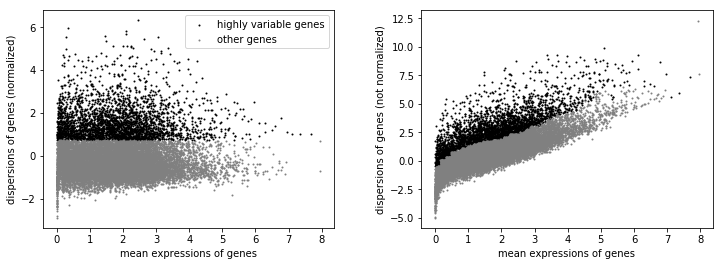

In [76]:
sc.pl.highly_variable_genes(adata_log, save="hvg.svg")

In [77]:
hvg = adata_log.var[adata_log.var['highly_variable']==True].index
samples = adata_log.obs.index

# Apply SBM

In [78]:
from sbmtm import sbmtm

/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/graph_tool/draw/libgraph_tool_draw.so: undefined symbol: _ZN5Cairo7Context9show_textERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(msg, RuntimeWarning)


In [79]:
model = sbmtm()

In [ ]:
model.make_graph_from_BoW_df(df.loc[hvg, samples])

In [ ]:
model.save_graph("graph.xml.gz")